In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [734]:
import sys
sys.path.append('/home/dfa/CCL-multimodal-attention/src')
from create_graphs import InferenceDataset, collate
from evaluation import Evaluation, overlaps, overlap_3, disease_dicts, disease_subtype_dict
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rdkit import Chem, DataStructs
from scipy import stats
from scipy.spatial.distance import pdist,squareform

In [4]:
sample_info = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/sample_info.csv', index_col=0)

* Load all models

In [6]:
nci_model_ppi3 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='NCI60', split='random', ppi_depth=3, seed=42)
nci_model_ppi2 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='NCI60', split='random', ppi_depth=2, seed=42)
nci_model_ppi1 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='NCI60', split='random', ppi_depth=1, seed=42)

gdsc_model_ppi3 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='random', ppi_depth=3, seed=42)
gdsc_model_ppi2 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='random', ppi_depth=2, seed=42)
gdsc_model_ppi1 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='random', ppi_depth=1, seed=42)

ctrp_model_ppi3 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='random', ppi_depth=3, seed=42)
ctrp_model_ppi2 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='random', ppi_depth=2, seed=42)
ctrp_model_ppi1 = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='random', ppi_depth=1, seed=42)

* Attention vectors

In [249]:
nci_model_3_attention = nci_model_ppi3.attention_links()
nci_model_2_attention = nci_model_ppi2.attention_links()
nci_model_1_attention = nci_model_ppi1.attention_links()

gdsc_model_3_attention = gdsc_model_ppi3.attention_links()
gdsc_model_2_attention = gdsc_model_ppi2.attention_links()
gdsc_model_1_attention = gdsc_model_ppi1.attention_links()

ctrp_model_3_attention = ctrp_model_ppi3.attention_links()
ctrp_model_2_attention = ctrp_model_ppi2.attention_links()
ctrp_model_1_attention = ctrp_model_ppi1.attention_links()

100%|██████████| 1226/1226 [39:18<00:00,  1.92s/it]


## Attention 3 plots

In [297]:
def attention_plot(gdsc_attention, ctrp_attention, nci_attention):
    cell_names = []
    attentions_gdsc = []
    attentions_ctrp = []
    attentions_nci = []
    primary_disease = []
    for i in gdsc_attention[0]: 
        attentions_gdsc.append(i['attention'].values)
    for i in ctrp_attention[0]: 
        attentions_ctrp.append(i['attention'].values)
    for i in nci_attention[0]: 
        attentions_nci.append(i['attention'].values)
    for i in gdsc_attention[1]: 
        primary_disease.append(sample_info.loc[sample_info['RRID'] == i]['primary_disease'][0])

    umapper_1 = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, learning_rate=0.1)
    umapper_2 = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, learning_rate=0.1)
    umapper_3 = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, learning_rate=0.1)

    gdsc_reduced = umapper_1.fit_transform(attentions_gdsc)
    ctrp_reduced = umapper_2.fit_transform(attentions_ctrp)
    nci_reduced = umapper_3.fit_transform(attentions_nci)

    #plt.rcParams.update({'axes.titlesize': 'medium'})
    fig, axes = plt.subplots(1, 3, figsize=(20,8))
    sns.scatterplot(x=gdsc_reduced[:,0], y=gdsc_reduced[:,1], hue=primary_disease, legend=False, ax = axes[0])
    sns.scatterplot(x=ctrp_reduced[:,0], y=ctrp_reduced[:,1], hue=primary_disease, legend=False, ax = axes[1])
    sns.scatterplot(x=nci_reduced[:,0], y=nci_reduced[:,1], hue=primary_disease, legend=False, ax = axes[2])
    axes[0].set_title('a) GDSC', loc='left', fontsize=15)
    axes[1].set_title('b) CTRP', loc='left', fontsize=15)
    axes[2].set_title('c) NCI 60', loc='left', fontsize=15)
    return fig

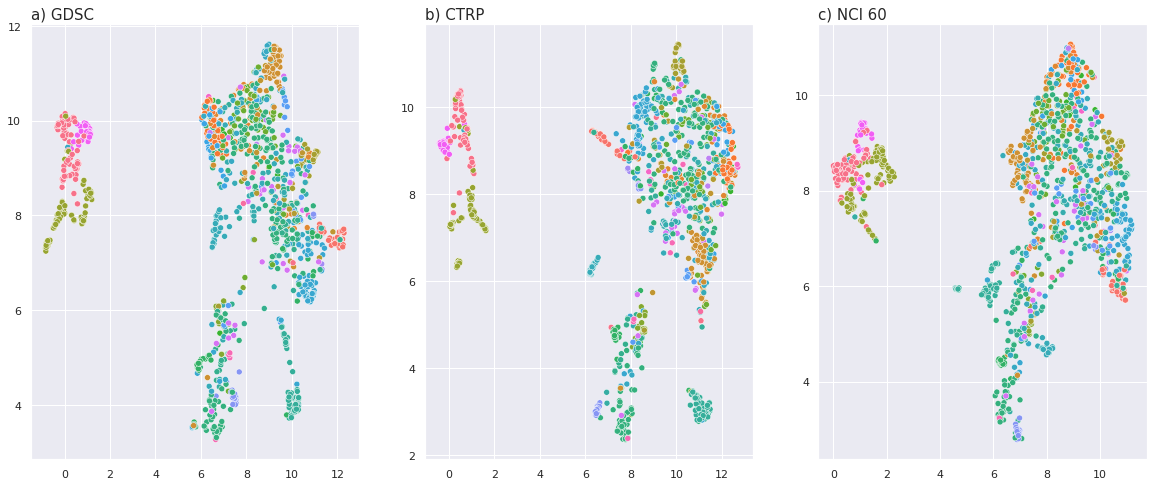

In [298]:
fig = attention_plot(gdsc_model_3_attention, ctrp_model_3_attention, nci_model_3_attention)
fig.savefig('/home/dfa/CCL-multimodal-attention/figures/umap_attention_ppi3.jpeg', bbox_inches='tight')

## Attention 1 plots

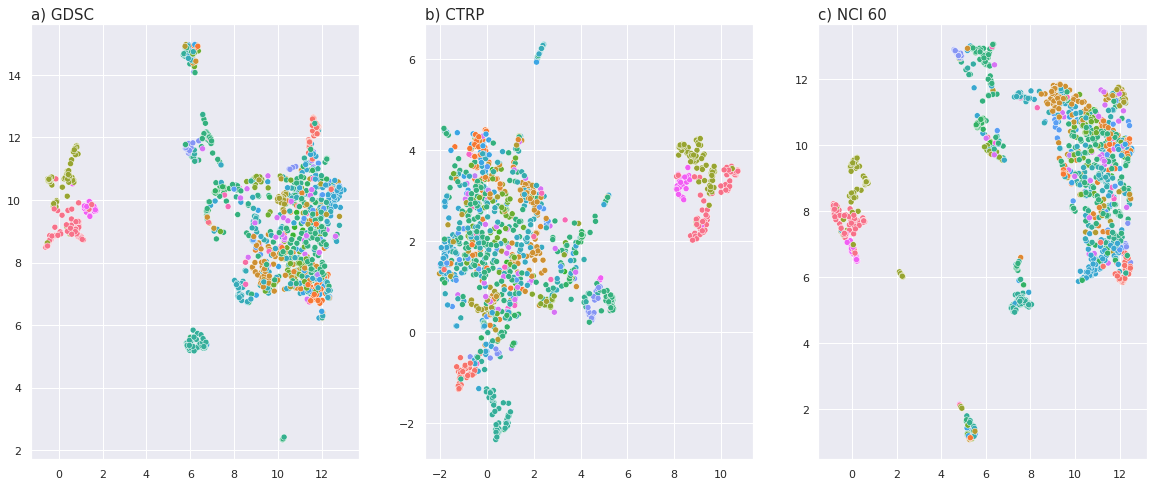

In [299]:
fig = attention_plot(gdsc_model_1_attention, ctrp_model_1_attention, nci_model_1_attention)
fig.savefig('/home/dfa/CCL-multimodal-attention/figures/umap_attention_ppi1.jpeg', bbox_inches='tight')

## Attention 2 plots

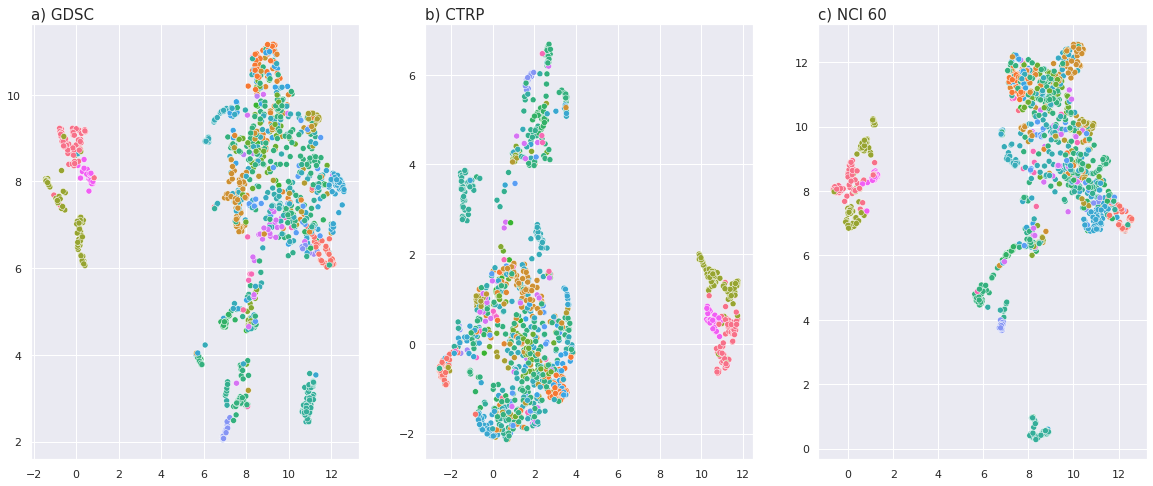

In [300]:
fig = attention_plot(gdsc_model_2_attention, ctrp_model_2_attention, nci_model_2_attention)
fig.savefig('/home/dfa/CCL-multimodal-attention/figures/umap_attention_ppi2.jpeg', bbox_inches='tight')

## Exploring effect of spaces on overlap

In [11]:
gdsc_drug_sim = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='drug_similarity', ppi_depth=1, seed=42)
ctrp_drug_sim = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='drug_similarity', ppi_depth=1, seed=42)
gdsc_drug_dis = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='drug_dissimilarity', ppi_depth=1, seed=42)
ctrp_drug_dis = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='drug_dissimilarity', ppi_depth=1, seed=42)

gdsc_cell_sim = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='cell_similarity', ppi_depth=1, seed=42)
ctrp_cell_sim = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='cell_similarity', ppi_depth=1, seed=42)
gdsc_cell_dis = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='GDSC', split='cell_dissimilarity', ppi_depth=1, seed=42)
ctrp_cell_dis = Evaluation('/home/dfa/CCL-multimodal-attention', dataset='CTRP', split='cell_dissimilarity', ppi_depth=1, seed=42)

gdsc_drug_sim_int = gdsc_drug_sim.interactions_dict(10)
ctrp_drug_sim_int = ctrp_drug_sim.interactions_dict(10)

gdsc_drug_dis_int = gdsc_drug_dis.interactions_dict(10)
ctrp_drug_dis_int = ctrp_drug_dis.interactions_dict(10)

gdsc_cell_sim_int = gdsc_cell_sim.interactions_dict(10)
ctrp_cell_sim_int = ctrp_cell_sim.interactions_dict(10)

gdsc_cell_dis_int = gdsc_cell_dis.interactions_dict(10)
ctrp_cell_dis_int = ctrp_cell_dis.interactions_dict(10)

results_drug_similarity = overlaps(gdsc_drug_sim_int, ctrp_drug_sim_int)
results_drug_dissimilarity = overlaps(gdsc_drug_dis_int, ctrp_drug_dis_int)
results_cell_similarity = overlaps(gdsc_cell_sim_int, ctrp_cell_sim_int)
results_cell_dissimilarity = overlaps(gdsc_cell_dis_int, ctrp_cell_dis_int)

In [717]:
np.mean(results_drug_similarity)

2.939641109298532

In [718]:
np.mean(results_drug_dissimilarity)

4.185154975530179

In [721]:
np.mean(results_cell_similarity)

2.5415986949429037

In [722]:
np.mean(results_cell_dissimilarity)

2.2096247960848285

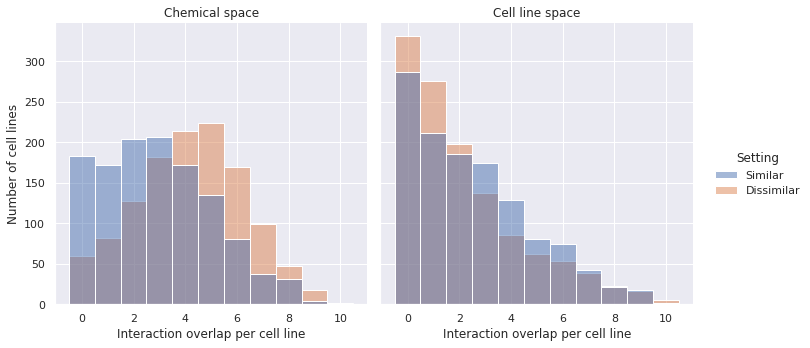

In [780]:
drug_similarity = pd.DataFrame({'Mean_cell_overlap': results_drug_similarity,
                                 'Setting': ['Similar' for i in range(0, 1226)],
                                'Space': ['Chemical space' for i in range(0, 1226)]})

drug_dissimilarity = pd.DataFrame({'Mean_cell_overlap': results_drug_dissimilarity,
                                 'Setting': ['Dissimilar' for i in range(0, 1226)],
                                  'Space': ['Chemical space' for i in range(0, 1226)]})

drug_similarity = pd.concat([drug_similarity, drug_dissimilarity])

cell_similarity = pd.DataFrame({'Mean_cell_overlap': results_cell_similarity,
                                 'Setting': ['Similar' for i in range(0, 1226)],
                               'Space': ['Cell line space' for i in range(0, 1226)]})

cell_dissimilarity = pd.DataFrame({'Mean_cell_overlap': results_cell_dissimilarity,
                                 'Setting': ['Dissimilar' for i in range(0, 1226)],
                                  'Space': ['Cell line space' for i in range(0, 1226)]})

cell_similarity = pd.concat([cell_similarity, cell_dissimilarity])

similarity = pd.concat([drug_similarity, cell_similarity])

sns.set(font_scale=1)
g = sns.displot(similarity, x='Mean_cell_overlap', hue='Setting', element='bars', col='Space', discrete=True)
g.set_axis_labels("Interaction overlap per cell line", "Number of cell lines")
g.set_titles("{col_name}", fontsize=100)
g.savefig('/home/dfa/CCL-multimodal-attention/figures/space_overlap.jpeg', bbox_inches='tight')

In [32]:
np.mean(results_drug_similarity)

2.939641109298532

In [35]:
np.mean(results_drug_dissimilarity)

4.185154975530179

* Tanimoto similarities

In [188]:
train_gdsc = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/CTRP_drug_similarity/train.csv')
train_ctrp = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/GDSC_drug_similarity/train.csv')

train_gdsc_dis = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/CTRP_drug_dissimilarity/train.csv')
train_ctrp_dis = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/GDSC_drug_dissimilarity/train.csv')

In [47]:
other_mols = [Chem.MolFromSmiles(x) for x in list(train_gdsc['smiles'].unique())]
other_fps = [Chem.RDKFingerprint(x) for x in other_mols]

data_cid = [x for x in list(train_ctrp['pubchem_cid'].unique())]
data_mols = [Chem.MolFromSmiles(x) for x in list(train_ctrp['smiles'].unique())]
data_fps = [Chem.RDKFingerprint(x) for x in data_mols]

average_similarity_data = []
for i in range(len(data_fps)):
    similarity_of_mol = []
    for j in range(len(other_fps)):
        similarity_of_mol.append(DataStructs.FingerprintSimilarity(data_fps[i], other_fps[j]))
    average_similarity_data.append(np.mean(similarity_of_mol))

* For similarity set

In [45]:
np.mean(average_similarity_data)

0.39246107694503324

* For disimilarity set

In [48]:
np.mean(average_similarity_data)

0.2869381949937636

* Tanimoto similarities for GDSC-NCI datasets

In [239]:
train_gdsc = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/GDSC_random/train.csv')
train_nci = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/NCI60_random/train.csv')

In [240]:
other_mols = [Chem.MolFromSmiles(x) for x in list(train_gdsc['smiles'].unique())]
other_fps = [Chem.RDKFingerprint(x) for x in other_mols]

data_cid = [x for x in list(train_ctrp['pubchem_cid'].unique())]
data_mols = [Chem.MolFromSmiles(x) for x in list(train_nci['smiles'].unique())]
data_fps = [Chem.RDKFingerprint(x) for x in data_mols]

average_similarity_data = []
for i in range(len(data_fps)):
    similarity_of_mol = []
    for j in range(len(other_fps)):
        similarity_of_mol.append(DataStructs.FingerprintSimilarity(data_fps[i], other_fps[j]))
    average_similarity_data.append(np.mean(similarity_of_mol))

In [241]:
np.mean(average_similarity_data)

0.28020578461240564

## Evaluate interactions

In [279]:
ctrp_interaction_1 = ctrp_model_ppi1.interactions_dict(10)

100%|██████████| 1226/1226 [35:31<00:00,  1.74s/it]


In [286]:
nci_interaction_1 = nci_model_ppi1.interactions_dict(10)
gdsc_interaction_1 = gdsc_model_ppi1.interactions_dict(10)

100%|██████████| 1226/1226 [36:31<00:00,  1.79s/it]


In [655]:
nci_interaction_2 = nci_model_ppi2.interactions_dict(10)
gdsc_interaction_2 = gdsc_model_ppi2.interactions_dict(10)
ctrp_interaction_2 = ctrp_model_ppi2.interactions_dict(10)

100%|██████████| 1226/1226 [39:10<00:00,  1.92s/it]


In [656]:
nci_interaction_3 = nci_model_ppi3.interactions_dict(10)
gdsc_interaction_3 = gdsc_model_ppi3.interactions_dict(10)
ctrp_interaction_3 = ctrp_model_ppi3.interactions_dict(10)

100%|██████████| 1226/1226 [41:09<00:00,  2.01s/it]


## Plot overlap distributions between different datasets

* 3 GAT Conv layers

In [657]:
overlap_nci_gdsc = overlaps(nci_interaction_3, gdsc_interaction_3)
overlap_nci_ctrp = overlaps(nci_interaction_3, ctrp_interaction_3)
overlap_gdsc_ctrp = overlaps(gdsc_interaction_3, ctrp_interaction_3)
overlap = overlap_3(gdsc_interaction_3, ctrp_interaction_3, nci_interaction_3)

df_overlap3 = pd.DataFrame({'GDSC_CTRP': overlap_gdsc_ctrp,
             'NCI_GDSC': overlap_nci_gdsc,
             'NCI_CTRP': overlap_nci_ctrp,
             'NCI_CTRP_GDSC': overlap})
df_overlap3 = df_overlap3.melt(var_name='Datasets', value_name='Overlap')
df_overlap3['Number of GATConv layers'] = '3'

* 2 GAT Conv layers

In [658]:
overlap_nci_gdsc = overlaps(nci_interaction_2, gdsc_interaction_2)
overlap_nci_ctrp = overlaps(nci_interaction_2, ctrp_interaction_2)
overlap_gdsc_ctrp = overlaps(gdsc_interaction_2, ctrp_interaction_2)
overlap = overlap_3(gdsc_interaction_2, ctrp_interaction_2, nci_interaction_2)

df_overlap2 = pd.DataFrame({'GDSC_CTRP': overlap_gdsc_ctrp,
             'NCI_GDSC': overlap_nci_gdsc,
             'NCI_CTRP': overlap_nci_ctrp,
             'NCI_CTRP_GDSC': overlap})
df_overlap2 = df_overlap2.melt(var_name='Datasets', value_name='Overlap')
df_overlap2['Number of GATConv layers'] = '2'

* 1 GAT Conv layer

In [659]:
overlap_nci_gdsc = overlaps(nci_interaction_1, gdsc_interaction_1)
overlap_nci_ctrp = overlaps(nci_interaction_1, ctrp_interaction_1)
overlap_gdsc_ctrp = overlaps(gdsc_interaction_1, ctrp_interaction_1)
overlap = overlap_3(gdsc_interaction_1, ctrp_interaction_1, nci_interaction_1)

df_overlap1= pd.DataFrame({'GDSC_CTRP': overlap_gdsc_ctrp,
             'NCI_GDSC': overlap_nci_gdsc,
             'NCI_CTRP': overlap_nci_ctrp,
             'NCI_CTRP_GDSC': overlap})
df_overlap1 = df_overlap1.melt(var_name='Datasets', value_name='Overlap')
df_overlap1['Number of GATConv layers'] = '1'

In [660]:
df_overlap = pd.concat([df_overlap3, df_overlap2, df_overlap1])

In [678]:
df_overlap = df_overlap.loc[df_overlap['Datasets'] != 'NCI_CTRP_GDSC']

In [800]:
help(g.set_titles)

Help on method set_titles in module seaborn.axisgrid:

set_titles(template=None, row_template=None, col_template=None, **kwargs) method of seaborn.axisgrid.FacetGrid instance
    Draw titles either above each facet or on the grid margins.
    
    Parameters
    ----------
    template : string
        Template for all titles with the formatting keys {col_var} and
        {col_name} (if using a `col` faceting variable) and/or {row_var}
        and {row_name} (if using a `row` faceting variable).
    row_template:
        Template for the row variable when titles are drawn on the grid
        margins. Must have {row_var} and {row_name} formatting keys.
    col_template:
        Template for the row variable when titles are drawn on the grid
        margins. Must have {col_var} and {col_name} formatting keys.
    
    Returns
    -------
    self: object
        Returns self.



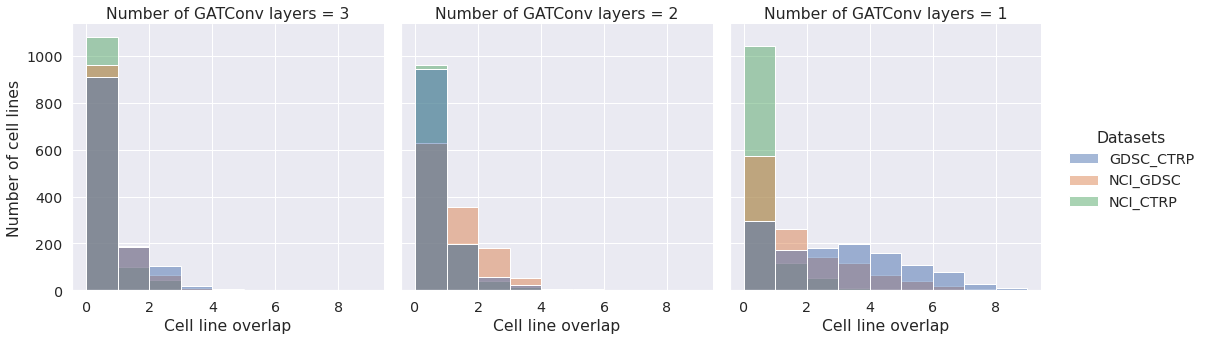

In [802]:
sns.set(rc={'figure.figsize':(10,8.27)})
sns.set(font_scale=1.3)
g = sns.displot(df_overlap, x='Overlap',  hue='Datasets', col='Number of GATConv layers', binwidth=1, multiple='layer')
g.set_axis_labels("Cell line overlap", "Number of cell lines")
g.savefig('/home/dfa/CCL-multimodal-attention/figures/kde, celline_overlap.jpeg', bbox_inches='tight')

## Primary disease overlap

In [409]:
gdsc_disease = disease_dicts(sample_info, gdsc_interaction_1, 'primary_disease')
ctrp_disease = disease_dicts(sample_info, ctrp_interaction_1, 'primary_disease')

In [473]:
def sort_disease(disease_dict, classification):
    diseases = []
    top10 = []
    for disease in disease_dict:
        num_cells = sample_info.loc[sample_info[classification] == disease]['RRID'].nunique()
        interactions = []
        num_interactions = []
        per_disease = disease_dict[disease]
        sorted_interactions = sorted(per_disease, key=per_disease.get, reverse=True)[:10]
        for i in sorted_interactions:
            num_interactions.append(round((per_disease[i] / num_cells)*100, 2))
            interactions.append(i)
        top10.append(dict(zip(interactions, num_interactions)))
        diseases.append(disease)

    return dict(zip(diseases, top10))

In [427]:
new_gdsc = sort_disease(gdsc_disease, 'primary_disease')
new_ctrp = sort_disease(ctrp_disease, 'primary_disease')

In [449]:
def disease_overlap(dict1, dict2):
    
    diseases = []
    overlapping_list = []
    for disease in dict1:
        per_disease_1 = dict1[disease]
        per_disease_2 = dict2[disease]
        
        diseases.append(disease)
        overlapping = []
        values = []
        for i in per_disease_1:
            value_1 = per_disease_1[i]
            if i in per_disease_2:
                value_2 = per_disease_2[i]
                overlapping.append(i)
                values.append([value_1, value_2])
        overlapping_list.append(dict(zip(overlapping, values)))
    
    return dict(zip(diseases, overlapping_list))

In [450]:
disease_overlap_dict = disease_overlap(new_gdsc, new_ctrp)

* Save table to file

In [462]:
diseases = []
interactions = []
gdsc_value = []
ctrp_value = []

for disease in disease_overlap_dict:
    per_disease = disease_overlap_dict[disease]
    for interaction in per_disease:
        gdsc_value.append(per_disease[interaction][0])
        ctrp_value.append(per_disease[interaction][1])
        interactions.append(interaction)
        diseases.append(disease)

In [463]:
disease_overlap_df = pd.DataFrame({'primary_disease': diseases,
                                  'interaction': interactions,
                                  'percent_overlap_GDSC': gdsc_value,
                                  'percent_overlap_CTRP': ctrp_value})

In [465]:
disease_overlap_df.to_csv('/home/dfa/CCL-multimodal-attention/figures/overlap_df.csv', index=False)

In [466]:
disease_overlap_dict

{'Ovarian Cancer': {'IGF1R-RASA1': [8.7, 5.8]},
 'Leukemia': {'UGDH-HSPB1': [25.78, 24.22],
  'CHEK2-RAD9A': [21.09, 15.62],
  'SHC1-IL4R': [19.53, 24.22],
  'RHOA-S100A4': [18.75, 13.28],
  'CDK4-CDKN1A': [13.28, 14.06]},
 'Colon/Colorectal Cancer': {'GLI2-USP7': [14.47, 17.11],
  'RAE1-MTHFD2': [11.84, 7.89],
  'GLI2-SMAD3': [10.53, 9.21]},
 'Skin Cancer': {'CHEK2-RAD9A': [15.84, 11.88],
  'CHEK2-GNAS': [14.85, 12.87],
  'NFKBIA-AKT1': [14.85, 10.89],
  'CHEK2-CHEK1': [13.86, 10.89],
  'UGDH-HSPB1': [12.87, 16.83]},
 'Bladder Cancer': {'INSIG1-HMGCR': [20.51, 17.95],
  'UBQLN2-EDEM1': [17.95, 17.95],
  'MBTPS1-HDAC2': [12.82, 15.38]},
 'Lung Cancer': {},
 'Kidney Cancer': {'UBQLN2-EDEM1': [25.0, 26.92],
  'INSIG1-HMGCR': [21.15, 28.85],
  'MBTPS1-HDAC2': [15.38, 25.0],
  'HDAC2-NR3C1': [7.69, 15.38]},
 'Breast Cancer': {'IFNAR1-CDK1': [8.64, 14.81]},
 'Pancreatic Cancer': {'HSPA8-CD40': [28.07, 22.81],
  'CCDC85B-ZFP36': [17.54, 8.77]},
 'Myeloma': {'SHC1-IL4R': [47.06, 52.94],
  'UG

## Interactions by cancer subtype

In [474]:
gdsc_disease_subtype = disease_dicts(sample_info, gdsc_interaction_1, 'Subtype')
ctrp_disease_subtype = disease_dicts(sample_info, ctrp_interaction_1, 'Subtype')

new_gdsc_subtype = sort_disease(gdsc_disease_subtype, 'Subtype')
new_ctrp_subtype = sort_disease(ctrp_disease_subtype, 'Subtype')

disease_overlap_dict_subtype = disease_overlap(new_gdsc_subtype, new_ctrp_subtype)

In [726]:
subtypes = []
subtype_interactions = []
gdsc_value = []
ctrp_value = []

for subtype in disease_overlap_dict_subtype:
    per_disease = disease_overlap_dict_subtype[subtype]
    for interaction in per_disease:
        gdsc_value.append(per_disease[interaction][0])
        ctrp_value.append(per_disease[interaction][1])
        subtype_interactions.append(interaction)
        subtypes.append(subtype)
        
subtype_overlap_df = pd.DataFrame({'primary_disease': subtypes,
                                  'interaction': subtype_interactions,
                                  'percent_overlap_GDSC': gdsc_value,
                                  'percent_overlap_CTRP': ctrp_value})    

In [727]:
subtype_overlap_df.to_csv('/home/dfa/CCL-multimodal-attention/figures/subtype_overlap_df.csv', index=False)

In [475]:
disease_overlap_dict_subtype

{'Adenocarcinoma, high grade serous': {},
 'Acute Myelogenous Leukemia (AML), M3 (Promyelocytic)': {'ILK-AKAP8': [33.33,
   33.33],
  'ILK-TUBB6': [33.33, 33.33],
  'GTF2A2-POLR2K': [33.33, 33.33]},
 'Adenocarcinoma': {'GLI2-USP7': [9.52, 12.7],
  'RAE1-MTHFD2': [8.73, 7.14],
  'HSPA8-CD40': [7.94, 8.73],
  'GLI2-SMAD3': [7.94, 7.14]},
 'Acute Myelogenous Leukemia (AML), M6 (Erythroleukemia)': {'PTK2B-SYK': [80.0,
   60.0],
  'IKBKB-NFKB2': [80.0, 60.0],
  'CDK4-CDKN1A': [60.0, 60.0],
  'CDK4-BCL2': [60.0, 40.0],
  'JUN-NOLC1': [40.0, 40.0]},
 'Acute Myelogenous Leukemia (AML), M5 (Eosinophilic/Monocytic)': {'SHC1-IL4R': [62.5,
   87.5],
  'RHOA-S100A4': [62.5, 62.5],
  'ILK-AKAP8': [37.5, 50.0],
  'RAE1-MTHFD2': [37.5, 37.5],
  'ILK-TUBB6': [37.5, 50.0],
  'UGDH-HSPB1': [25.0, 37.5],
  'CHEK2-RAD9A': [25.0, 37.5]},
 'Melanoma': {'NFKBIA-AKT1': [18.29, 13.41],
  'CHEK2-RAD9A': [17.07, 12.2],
  'CHEK2-GNAS': [14.63, 12.2],
  'CHEK2-CHEK1': [13.41, 10.98],
  'UGDH-HSPB1': [13.41, 18.29]}

## Interactions by both primary disease and subtype

In [739]:
gdsc_disease_subtype = disease_subtype_dict(sample_info, gdsc_interaction_1)
ctrp_disease_subtype = disease_subtype_dict(sample_info, ctrp_interaction_1)

In [740]:
def sort_disease(disease_dict):
    diseases = []
    top10 = []
    for disease in disease_dict:
        primary = disease.split('_')[0]
        subtype = disease.split('_')[1]
        num_cells = sample_info.loc[(sample_info['primary_disease'] == primary) &
                                   (sample_info['Subtype'] == subtype)]['RRID'].nunique()
        interactions = []
        num_interactions = []
        per_disease = disease_dict[disease]
        sorted_interactions = sorted(per_disease, key=per_disease.get, reverse=True)[:10]
        for i in sorted_interactions:
            num_interactions.append(round((per_disease[i] / num_cells)*100, 2))
            interactions.append(i)
        top10.append(dict(zip(interactions, num_interactions)))
        diseases.append(disease)

    return dict(zip(diseases, top10))

In [741]:
new_gdsc_disease_subtype = sort_disease(gdsc_disease_subtype)
new_ctrp_disease_subtype = sort_disease(ctrp_disease_subtype)

In [742]:
disease_overlap_primary_subtype_dict = disease_overlap(new_gdsc_disease_subtype, new_ctrp_disease_subtype)

In [745]:
disease_overlap_primary_subtype_dict

{'Ovarian Cancer_Adenocarcinoma, high grade serous': {},
 'Ovarian Cancer_Adenocarcinoma, endometrioid': {},
 'Ovarian Cancer_Adenocarcinoma, serous': {},
 'Ovarian Cancer_Adenocarcinoma, mucinous': {'PPP2R5A-CSNK1A1': [33.33, 33.33],
  'CDK1-PIN1': [33.33, 33.33]},
 'Ovarian Cancer_Carcinoma, brenner': {'INSIG1-HMGCR': [100.0, 100.0],
  'CHEK1-MSH6': [100.0, 100.0],
  'UBQLN2-RNH1': [100.0, 100.0],
  'MBTPS1-HDAC2': [100.0, 100.0]},
 'Ovarian Cancer_Adenocarcinoma, clear cell': {'CCNE2-PCNA': [33.33, 22.22],
  'RFX5-HDAC2': [22.22, 22.22],
  'HDAC2-NR3C1': [22.22, 44.44],
  'UBQLN2-EDEM1': [11.11, 11.11]},
 'Ovarian Cancer_Adenocarcinoma, low grade serous': {},
 'Ovarian Cancer_Cystadenocarcinoma, high grade serous': {'UBQLN2-EDEM1': [100.0,
   100.0],
  'MBTPS1-HDAC2': [100.0, 100.0],
  'INSIG1-HMGCR': [100.0, 100.0],
  'UBQLN2-RNH1': [100.0, 100.0]},
 'Ovarian Cancer_Adenocarcinoma, mixed': {'PARP1-CEBPA': [50.0, 50.0],
  'SCCPDH-SQSTM1': [50.0, 50.0],
  'KAT6A-HSPA4': [50.0, 50.0],

In [747]:
subtypes = []
subtype_interactions = []
gdsc_value = []
ctrp_value = []

for subtype in disease_overlap_primary_subtype_dict:
    per_disease = disease_overlap_primary_subtype_dict[subtype]
    for interaction in per_disease:
        gdsc_value.append(per_disease[interaction][0])
        ctrp_value.append(per_disease[interaction][1])
        subtype_interactions.append(interaction)
        subtypes.append(subtype)
        
primary_disease_subtype_overlap_df = pd.DataFrame({'primary_disease_subtype': subtypes,
                                  'interaction': subtype_interactions,
                                  'percent_overlap_GDSC': gdsc_value,
                                  'percent_overlap_CTRP': ctrp_value})   

In [748]:
primary_disease_subtype_overlap_df.to_csv('/home/dfa/CCL-multimodal-attention/figures/primary_subtype_overlap_df.csv', index=False)

In [756]:
sample_info['lineage'].value_counts()

lung                                 273
blood                                132
skin                                 113
lymphocyte                           109
central_nervous_system               107
colorectal                            83
breast                                82
upper_aerodigestive                   76
bone                                  75
ovary                                 74
soft_tissue                           71
pancreas                              59
kidney                                57
gastric                               49
peripheral_nervous_system             47
unknown                               45
fibroblast                            43
bile_duct                             43
uterus                                39
urinary_tract                         39
esophagus                             38
plasma_cell                           34
liver                                 27
cervix                                22
thyroid         

In [761]:
labeled_data = pd.read_csv('/home/dfa/CCL-multimodal-attention/data/processed/labeled_data.csv')

In [768]:
labeled_data.loc[labeled_data['dataset_name'] == 'CTRP']['sensitivity_uM'].value_counts(normalize=True)

0    0.82726
1    0.17274
Name: sensitivity_uM, dtype: float64